In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from rfpimp import *
from sklearn.model_selection import train_test_split
from sklearn.base import clone


In [10]:
df_all = pd.read_csv("data/rent-cls.csv") 

num_features = ['bathrooms','bedrooms','latitude','longitude','price']
target = 'interest_level'

df = df_all[num_features + [target]]

In [11]:
# compute median per num bedrooms
df = df.copy()
df_median_price_per_bedrooms = df.groupby(by='bedrooms')['price'].median().reset_index()
beds_to_median = df_median_price_per_bedrooms.to_dict(orient='dict')['price']
df['median_price_per_bedrooms'] = df['bedrooms'].map(beds_to_median)
# compute ratio of price to median price for that num of bedrooms
df['price_to_median_beds'] = df['price'] / df['median_price_per_bedrooms']
# ratio of num bedrooms to price
df["beds_per_price"] = df["bedrooms"] / df["price"] 
# total rooms (bed, bath)
df["beds_baths"] = df["bedrooms"]+df["bathrooms"]
del df['median_price_per_bedrooms'] # don't need after computation

df_train, df_test = train_test_split(df, test_size=0.15)

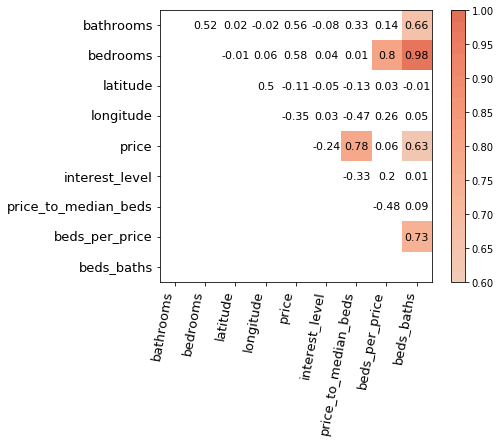

In [12]:
from rfpimp import plot_corr_heatmap
plot_corr_heatmap(df_train, figsize=(7,5), label_fontsize=13, value_fontsize=11)

In [13]:
X_train, y_train = df_train.drop('interest_level',axis=1), df_train['interest_level']
X_test, y_test = df_test.drop('interest_level',axis=1), df_test['interest_level']

rf = RandomForestClassifier(n_estimators=100, n_jobs=-1,
#                            max_features=X_train.shape[1]-1,
                            max_features=1.0,
                            min_samples_leaf=10, oob_score=True)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=1.0, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

Without specifying a feature list, the default is to give you each column as an individual feature:

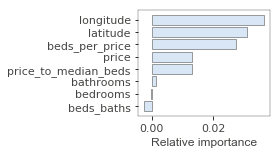

In [14]:
I = importances(rf, X_test, y_test)
plot_importances(I, filename='/Users/parrt/github/random-forest-importances/article/images/imp.svg')

But you can specify a subset if you like:

[5 2 1]
8
[2.5 1.  0.5]


ValueError: shape mismatch: objects cannot be broadcast to a single shape

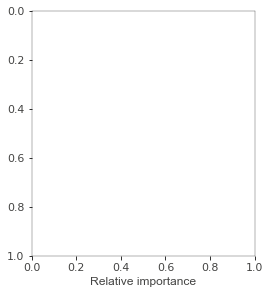

In [35]:
def plot_importances(df_importances,
                     filename=None,
                     yrot=0,
                     label_fontsize=11,
                     width=4,
                     show=True,
                     color='#D9E6F5'):
    """
    Given an array or data frame of importances, plot a horizontal bar chart
    showing the importance values.

    :param df_importances: A data frame with Feature, Importance columns
    :type df_importances: pd.DataFrame
    :param filename: A filename identifying where to save the image.
    :param width: Figure width in default units (inches I think). Height determined
                  by number of features.
    :type width: int
    :param yrot: Degrees to rotate feature (Y axis) labels
    :type yrot: int
    :param label_fontsize:  The font size for the column names and x ticks
    :type label_fontsize:  int
    :param scalefig: Scale width and height of image (widthscale,heightscale)
    :type scalefig: 2-tuple of floats
    :param show: Execute plt.show() if true (default is True). Sometimes
                 we want to draw multiple things before calling plt.show()
    :type show: bool
    :return: None

    SAMPLE CODE

    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
    X_train, y_train = ..., ...
    rf.fit(X_train, y_train)
    imp = importances(rf, X_test, y_test)
    plot_importances(imp)
    """
    GREY = '#444443'
    I = df_importances
#     N = len(I.index)
    unit = .5
    minheight=1.5

    barwidths = np.array([f.count('\n')+1 for f in I.index])
    print(barwidths)
    N = np.sum(barwidths)
    barwidths = barwidths * unit
    print(N)
    print(barwidths)
    height = max(minheight,(N+1)*unit)
    fig = plt.figure(figsize=(width,height))
    ax = plt.gca()
    ax.spines['top'].set_linewidth(.3)
    ax.spines['right'].set_linewidth(.3)
    ax.spines['left'].set_linewidth(.3)
    ax.spines['bottom'].set_linewidth(.3)

    yloc = np.arange(0,N*unit,unit)
    imp = I.Importance.values
    ax.tick_params(labelsize=label_fontsize, labelcolor=GREY)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel("Relative importance", fontsize=label_fontsize+1, fontname="Arial", color=GREY)
    barcontainer = plt.barh(y=yloc, width=imp, height=barwidths*.8, tick_label=I.index, color=color)

    # Alter appearance of each bar
    for rect in barcontainer.patches:
            rect.set_linewidth(.5)
            rect.set_edgecolor(GREY)

    # rotate y-ticks
    if yrot is not None:
        plt.yticks(rotation=yrot)

    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', pad_inches=0)
    if show:
        plt.show()

I = importances(rf, X_test, y_test, features=['price',['latitude','longitude']])
plot_importances(I, filename='/Users/parrt/github/random-forest-importances/article/images/subset_imp.svg')

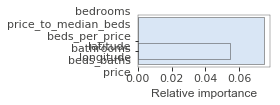

In [31]:
I = importances(rf, X_test, y_test, features=[['latitude','longitude']])
plot_importances(I, filename='/Users/parrt/github/random-forest-importances/article/images/latlong_imp.svg')

By specifying a list of lists, you can provide groups that should be treated together.

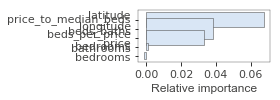

In [32]:
features = ['bathrooms', 'bedrooms', 
            ['latitude', 'longitude'],  
            ['price_to_median_beds', 'beds_baths', 'price'], 
            ['beds_per_price','bedrooms']]
I = importances(rf, X_test, y_test, features=features)
plot_importances(I, filename='/Users/parrt/github/random-forest-importances/article/images/grouped_imp.svg')

Features can be duplicated in multiple groups:

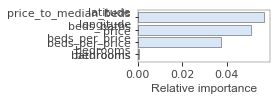

In [18]:
features = [['latitude', 'longitude'],
            ['price_to_median_beds', 'beds_baths', 'beds_per_price', 'bedrooms'],
            ['price','beds_per_price','bedrooms']]
I = importances(rf, X_test, y_test, features=features)
plot_importances(I, filename='/Users/parrt/github/random-forest-importances/article/images/grouped_dup_imp.svg')